# Exploration of high-dimensional analysis of primary cultures spike train data

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import glob

#### Overview of the data

In [2]:
folders = glob.glob('C:\\Users\\bow-lab\\Documents\\Code\\data\\DataXENON\\000*')

files = []

for folder in folders:
    files.append(f'{folder}/sorted.npz')

data = np.load(files[0], allow_pickle=True)

keys = list(data.keys())

for key in keys:
    content = data[key]
    print(key.ljust(10),
          str(np.shape(content)).ljust(10),
          str(type(content)))
    
units = data['units']
locations = data['locations']
samplerate = int(data['fs'])

units      (136,)     <class 'numpy.ndarray'>
locations  (964, 2)   <class 'numpy.ndarray'>
fs         ()         <class 'numpy.ndarray'>
spike_times (446057,)  <class 'numpy.ndarray'>


In [3]:
units_keys = units[0].keys()

print('Units consists of an array of dictionary with more data', end='\n\n')

for key in units_keys:
    content = units[1][key]
    print(key.ljust(12),
          str(np.shape(content)).ljust(12),
          str(type(content)))

Units consists of an array of dictionary with more data

unit_id      ()           <class 'int'>
spike_train  (7067,)      <class 'numpy.ndarray'>
x_max        ()           <class 'numpy.float64'>
y_max        ()           <class 'numpy.float64'>
template     (81, 964)    <class 'numpy.memmap'>
sorted_index ()           <class 'int'>
max_channel_si ()           <class 'numpy.int32'>
max_channel_id ()           <class 'numpy.str_'>
peak_sign    ()           <class 'str'>
peak_ind     (964,)       <class 'numpy.ndarray'>
amplitudes   (964,)       <class 'numpy.ndarray'>
std_norms    (964,)       <class 'numpy.ndarray'>
electrode    ()           <class 'numpy.int32'>


### Pre-processing the data

Order the data from most to least active unit and obtain the last frame (`total_size`) at which a firing happened, i.e. the total number of frames. 

In [4]:
activity = np.array([])
total_size = 0

for unit in units:
    activity = np.append(activity, len(unit['spike_train']))

    try:
        if unit['spike_train'][-1] > total_size:
            total_size = unit['spike_train'][-1]
    except:
        continue
 

unit_number = np.arange(0, len(units))
units = units[np.argsort(-1*activity)]

Create a binary array of size `(#units, total_size)` with a value `1` if the unit has fired, and `0` if it did not fire. 

In [5]:
binary_firings = np.full( (len(units), total_size+1), False, dtype=np.bool_)

for i, unit in enumerate(units):
    binary_firings[i][unit['spike_train']] = True

From this binary array we can obtain the firing rate per frame by summing over all units each time step. Because of the high frame rate this gives a very noisy output. We therefore take a running average. To reduce the amount of data and computation time we take an average every `step` frames. 

In [11]:
firing_rate = np.sum(binary_firings, axis=0) #get firing rate per frame

window_size = 0.02 # seconds
window = samplerate * window_size # window in number of frames
step = window / 20

time = np.arange(0, len(firing_rate)/samplerate, 1/samplerate)

firing_rate_avg = []
time_avg = []

for i in range(0, len(firing_rate), int(step)):

    firing_rate_avg.append(np.sum(firing_rate[i:i+int(window)])/window_size)
    
    time_avg.append(time[i]+window_size)

firing_rate_avg = np.array(firing_rate_avg)
time_avg = np.array(time_avg)


Now we can plot the data

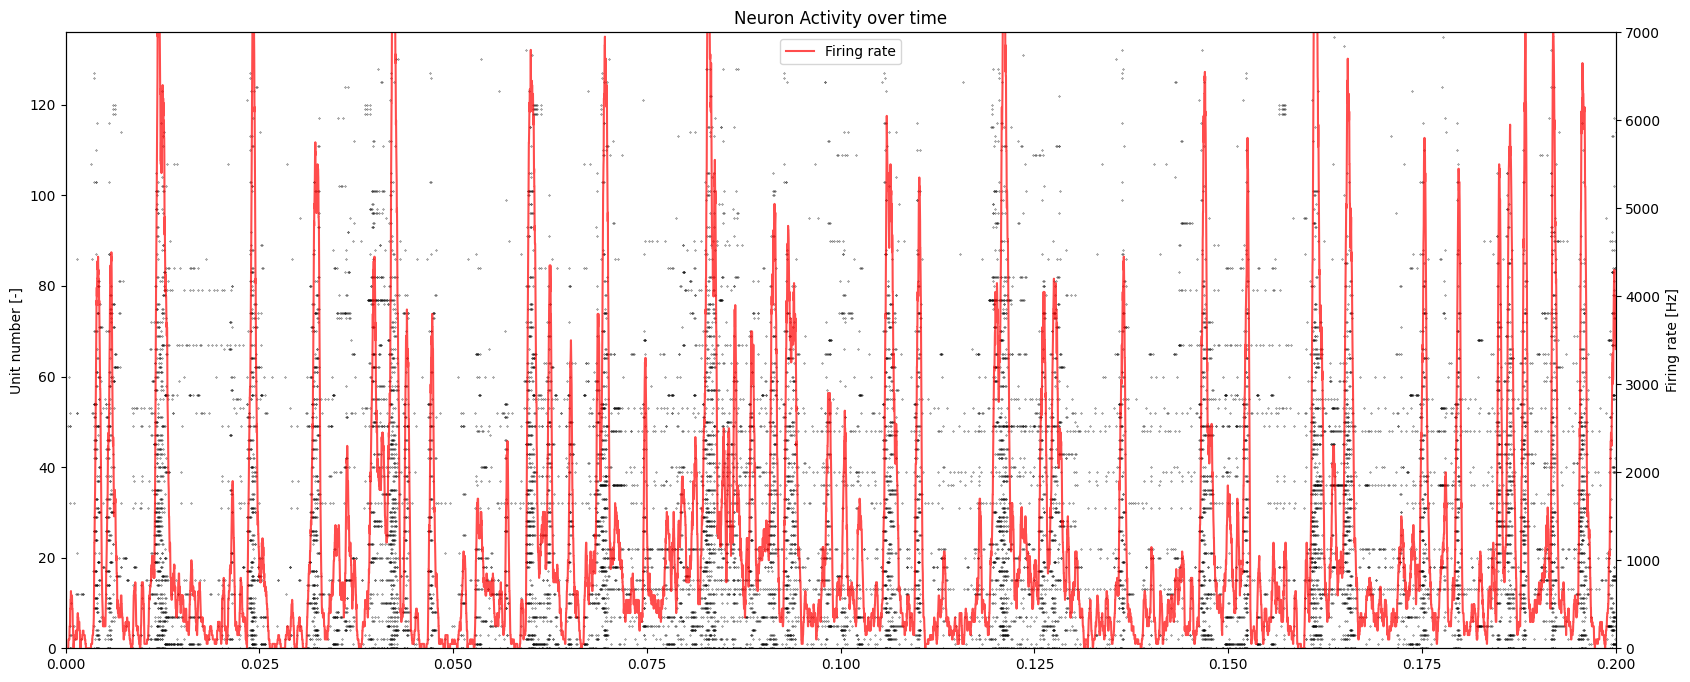

Total measurement time: 5 min 0.038 s


In [15]:
fig, ax1 = plt.subplots(figsize=(20, 8))

plt.title('Neuron Activity over time')

for i, unit in enumerate(units):
    ax1.scatter(unit['spike_train']/samplerate/60, 
                np.full_like(unit['spike_train'], unit_number[i]), 
                s=.07, color='k')

ax1.set_ylabel('Unit number [-]')
ax1.set_ylim(0, len(units))

ax2 = ax1.twinx() 
ax2.plot(time_avg/60, firing_rate_avg, c='r', alpha=.7, label='Firing rate')
ax2.set_ylim(0, 7000)
ax2.set_ylabel('Firing rate [Hz]')
ax2.legend()

plt.xlabel('Time [min]')
plt.xlim(0, .2)
plt.show()

print(f'Total measurement time: {int(time[-1]//60)} min {round(time[-1]%60, 3)} s')

### Implementing TJ method of obtaining firing rates
First apply the method to a few spike trains to see how it works

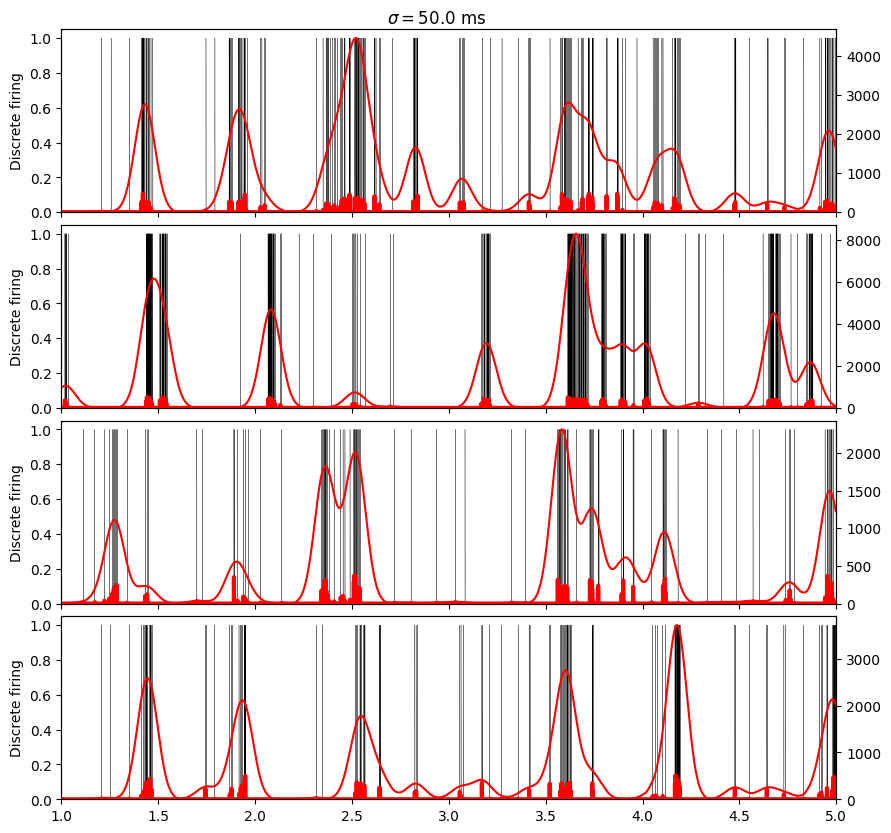

In [16]:
def gaussian_kernel(size, sigma):
    x = np.linspace(-size // 2, size // 2, int(size))
    kernel = np.exp(-x**2 / (2 * sigma**2))
    return kernel

def convolution(input, kernel, stride=1, padding='same'):
    input_length = len(input)
    kernel_length = len(kernel)
    output_length = (input_length - kernel_length) // stride + 1

    if padding == 'same':
        pad_size = (kernel_length - 1) // 2
        input = np.pad(input, (pad_size, pad_size), mode='constant')
    elif padding == 'valid':
        pad_size = 0
    else:
        raise ValueError("Padding must be either 'same' or 'valid'")
    
    padded_input_length = len(input)

    output_length = (padded_input_length - kernel_length) // stride + 1

    output = np.zeros(output_length)

    for i in range(0, output_length):
        start_index = i * stride
        output[i] = np.dot(input[start_index:start_index + kernel_length], kernel)

    return output


kernel_size = .3 # seconds
sigma = .05 # seconds
stride = 50 # seconds * samplerate
gaussian = gaussian_kernel(kernel_size*samplerate, sigma*samplerate)

fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
plt.subplots_adjust(hspace=.07)
plt.suptitle(r'$\sigma =$'+str(sigma*1e3)+' ms', y=.9)

time_xlim = (1, 5)

for i, ax in enumerate(axs):

    spike_train = units[i]['spike_train']
    isi = np.diff(spike_train)
    isi_rate = 1/(isi/samplerate)

    firing_rate_binary = np.zeros(total_size)
    
    firing_rate_binary[spike_train[:-1]] = isi_rate

    # only convolve and plot part to save time
    index_min = np.argmin(np.abs(time - time_xlim[0]))
    index_max = np.argmin(np.abs(time - time_xlim[1]))

    firing_rate_smooth = convolution(firing_rate_binary[index_min:index_max], gaussian, stride=stride)

    ax.plot(time[index_min:index_max], binary_firings[i][index_min:index_max], c='k', alpha=1, linewidth=.2)

    axright = ax.twinx()
    
    axright.plot(time[index_min:index_max], firing_rate_binary[index_min:index_max], c='r', linewidth=3)
    axright.plot(time[index_min:index_max:stride], firing_rate_smooth, c='r')
    axright.set_ylim(0)
    ax.set_ylabel('Discrete firing')
    ax.set_ylim(0)

plt.xlabel('Time [ms]')
plt.xlim(time_xlim)
plt.show()

In [17]:
for i, unit in tqdm(enumerate(units)):

    spike_train = np.unique(unit['spike_train'])
    isi = np.diff(spike_train)
    isi_rate = 1/(isi/samplerate)    

    firing_rate_binary = np.zeros(total_size)
    
    firing_rate_binary[spike_train[:-1]] = isi_rate

    firing_rate_smooth = convolution(firing_rate_binary, gaussian, stride=stride)

    if i==0:
        firing_rates = firing_rate_smooth
    else:
        firing_rates = np.vstack((firing_rates, firing_rate_smooth))


136it [00:30,  4.47it/s]


(array([9.213e+03, 6.720e+02, 3.630e+02, 3.260e+02, 2.890e+02, 2.480e+02,
        1.760e+02, 1.470e+02, 1.260e+02, 9.400e+01, 9.100e+01, 6.000e+01,
        6.300e+01, 7.000e+01, 5.900e+01, 4.900e+01, 4.600e+01, 4.400e+01,
        3.600e+01, 3.400e+01, 2.200e+01, 2.100e+01, 1.600e+01, 1.200e+01,
        6.000e+00, 7.000e+00, 5.000e+00, 4.000e+00, 2.000e+00, 3.000e+00,
        5.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([1.000000e+00, 2.510250e+02, 5.010500e+02, 7.510750e+02,
        1.001100e+03, 1.251125e+03, 1.501150e+03, 1.751175e+03,
        2.001200e+03, 2.251225e+03, 2.501250e+03, 2.751275e+03,
        3.001300e+03, 3.251325e+03, 3.501350e+03, 3.751375e+03,
        4.001400e+03, 4.251425e+03, 4.501450e+03, 4.751475e+03,
        5.001500e+03, 5.251525e+03, 5.501550e+03, 5.751575e+03,
        6.001600e+03, 6.251625e+03, 6.501650e+03, 6.751675e+03,
        7.001700e+03, 7.251725e+03, 7.501750e+03, 7.75

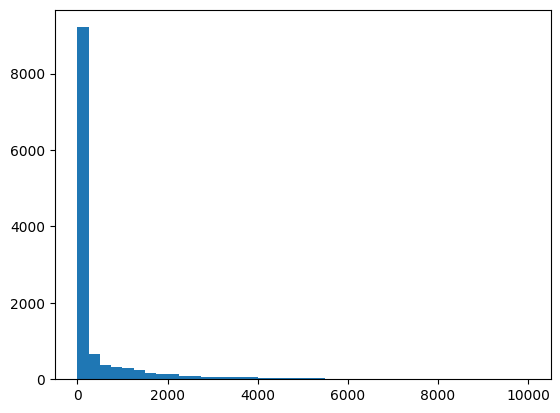

In [18]:
spike_train = units[0]['spike_train']
isi = np.diff(spike_train)
plt.hist(isi, bins=40)

In [19]:
np.savetxt('firing_rates_smooth_50ms.csv', firing_rates, delimiter=',')

In [10]:
firing_rates = np.loadtxt('firing_rates_smooth_50ms.csv', delimiter=',')

#### PCA

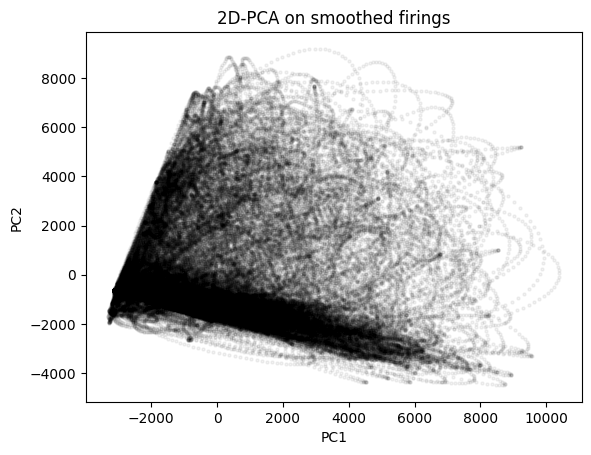

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
PCA_smooth_2d = pca.fit_transform(firing_rates.T)

plt.figure()
plt.title('2D-PCA on smoothed firings')
plt.scatter(PCA_smooth_2d[:,0], PCA_smooth_2d[:,1], s=5, alpha=.05, c='k')
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.xlim(-.01, .2)
#plt.ylim(-1000, 5000)
plt.show()

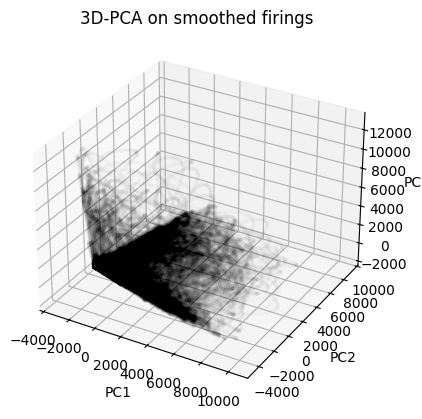

In [34]:
pca = PCA(n_components=3)
PCA_smooth_3d = pca.fit_transform(firing_rates.T)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('3D-PCA on smoothed firings')
ax.scatter(PCA_smooth_3d[:,0], PCA_smooth_3d[:,1], PCA_smooth_3d[:,2], s=5, c='k', marker='o', alpha=.01)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

#### t-SNE

In [26]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_smooth_2d = tsne.fit_transform(firing_rates.T)

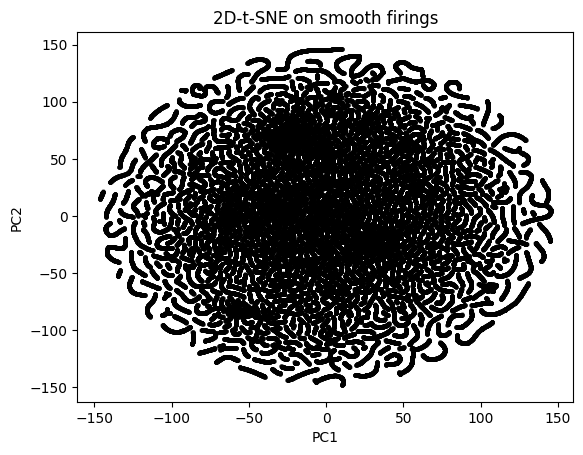

In [27]:
plt.figure()
plt.title('2D-t-SNE on smooth firings')
plt.scatter(tsne_smooth_2d[:,0], tsne_smooth_2d[:,1], s=5, alpha=.5, c='k')
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.xlim(-200, 200)
#plt.ylim(-200, 200)
plt.show()

In [16]:
tsne = TSNE(n_components=2)
tsne_smooth_2d = tsne.fit_transform(firing_rates.T)

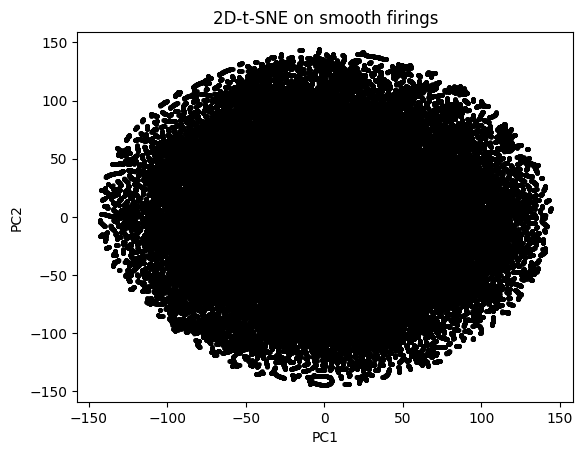

In [17]:
plt.figure()
plt.title('2D-t-SNE on smooth firings')
plt.scatter(tsne_smooth_2d[:,0], tsne_smooth_2d[:,1], s=5, alpha=.5, c='k')
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.xlim(-200, 200)
#plt.ylim(-200, 200)
plt.show()

In [39]:
tsne = TSNE(n_components=3)
tsne_smooth_3d = tsne.fit_transform(firing_rates.T)

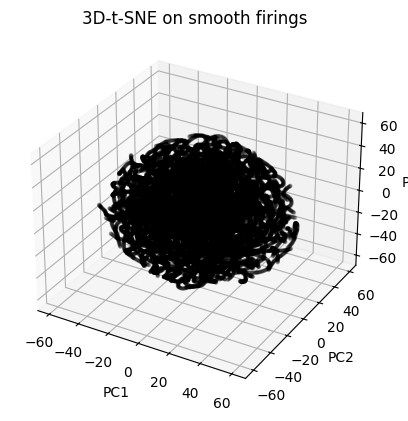

In [40]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.set_title('3D-t-SNE on smooth firings')
ax.scatter(tsne_smooth_3d[:,0], tsne_smooth_3d[:,1], tsne_smooth_3d[:,2], s=5, c='k', marker='o', alpha=.05)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
#ax.set_xlim(-10, 20)
#ax.set_ylim(-10, 20)
#ax.set_zlim(-20, 20)
plt.show()

Now lets zoom in on only a small part of the data

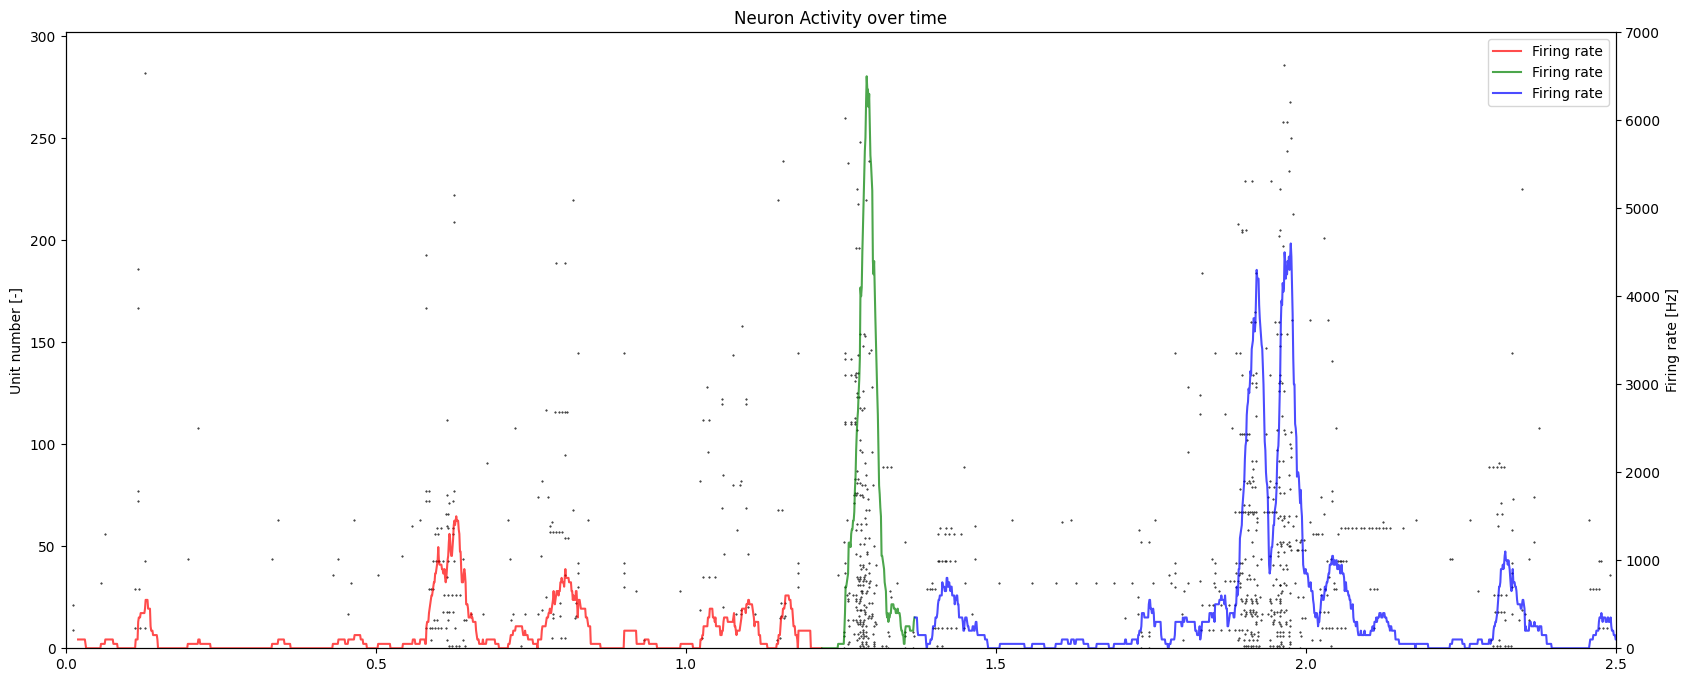

In [20]:
bereik = 50000

fig, ax1 = plt.subplots(figsize=(20, 8))

plt.title('Neuron Activity over time')

for i, unit in enumerate(units):
    spike_train = unit['spike_train']
    spike_train_sliced = spike_train[spike_train<=int(bereik)]
    ax1.scatter(spike_train_sliced/samplerate, 
                np.full_like(spike_train_sliced, unit_number[i]), 
                s=.2, color='k')

section1 = samplerate*np.array([0, 1.2]) # seconds
section2 = samplerate*np.array([1.2, 1.35]) # seconds
section3 = samplerate*np.array([1.35, 5]) # seconds

sections = np.array([section1, section2, section3]).astype(int)
sections_avg = (sections/step).astype(int)

colors = ['r', 'g', 'b']

ax1.set_ylabel('Unit number [-]')
ax1.set_ylim(0, len(units))

ax2 = ax1.twinx() 

for section, c in zip(sections_avg, colors):
    ax2.plot(time_avg[section[0]:section[1]], firing_rate_avg[section[0]:section[1]], c=c, alpha=.7, label='Firing rate')

ax2.set_ylim(0, 7000)
ax2.set_ylabel('Firing rate [Hz]')
ax2.legend()
plt.xlim(0, time[bereik])
plt.xlabel('Time [min]')
plt.show()

In [30]:
tsne = TSNE(n_components=2)
tsne_smooth_2d = tsne.fit_transform(firing_rates[:,:bereik//stride].T)

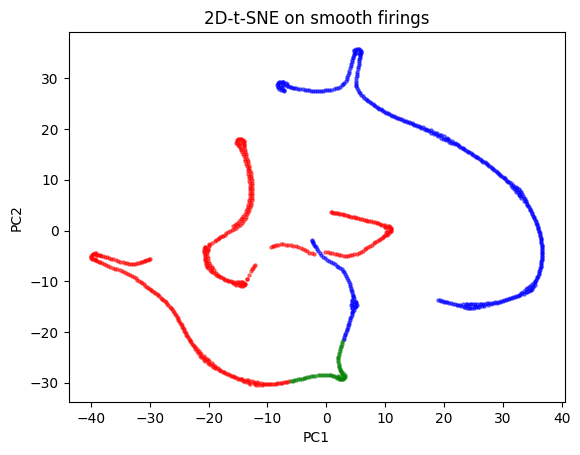

In [32]:
sections_tsne = (sections/stride).astype(int)

plt.figure()
plt.title('2D-t-SNE on smooth firings')
for section, c in zip(sections_tsne, colors):
    plt.scatter(tsne_smooth_2d[section[0]:section[1],0], tsne_smooth_2d[section[0]:section[1],1], s=5, alpha=.5, c=c)
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.xlim(-1e3, 6e3)
#plt.ylim(-1e3, 3e3)
plt.show()

In [28]:
import umap.umap_ as umap

umap_model = umap.UMAP(n_components=2)
umap_smooth_2d = umap_model.fit_transform(firing_rates.T)

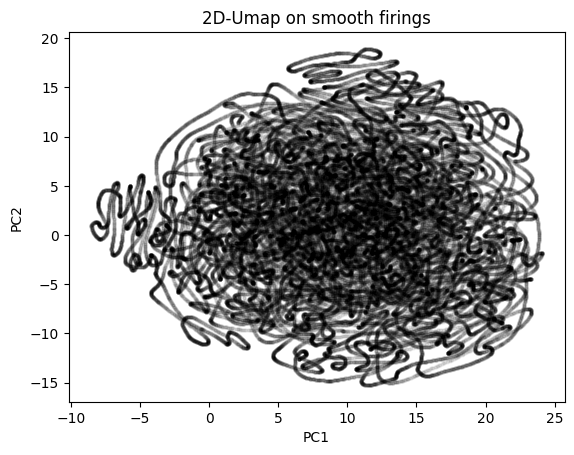

In [30]:
plt.figure()
plt.title('2D-Umap on smooth firings')
plt.scatter(umap_smooth_2d[:,0], umap_smooth_2d[:,1], s=5, alpha=.05, c='k')
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.xlim(-.01, .2)
#plt.ylim(-0.01, .4)
plt.show()

In [31]:
umap_model = umap.UMAP(n_components=3)
umap_smooth_3d = umap_model.fit_transform(firing_rates.T)

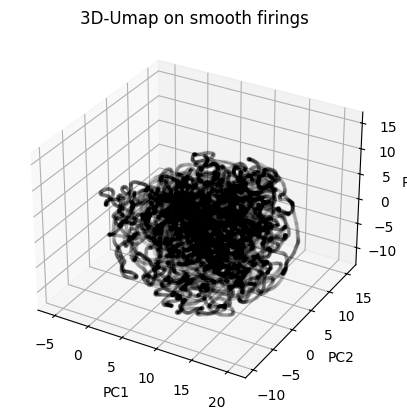

In [33]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.set_title('3D-Umap on smooth firings')
ax.scatter(umap_smooth_3d[:,0], umap_smooth_3d[:,1], umap_smooth_3d[:,2], s=5, c='k', marker='o', alpha=.01)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

In [36]:
import numpy as np

def calculate_radial_density(points, num_bins=50, r_max=None):
    """
    Calculate the radial density of points in 3D space.
    
    Parameters:
    - points (numpy.ndarray): Array of shape (N, 3) representing the 3D coordinates of the points.
    - num_bins (int): Number of bins to use for the radial density calculation.
    - r_max (float or None): Maximum radius for calculating radial density. If None, uses the maximum distance from center.
    
    Returns:
    - bin_centers (numpy.ndarray): Array of shape (num_bins,) with the center of each radial bin.
    - radial_density (numpy.ndarray): Array of shape (num_bins,) with the density in each radial bin.
    """
    # Calculate the centroid (center) of the points
    center = np.mean(points, axis=0)
    
    # Calculate the radial distance of each point from the center
    distances = np.linalg.norm(points - center, axis=1)
    
    # Set r_max to the maximum distance if not provided
    if r_max is None:
        r_max = distances.max()
    
    # Define the radial bins
    bin_edges = np.linspace(0, r_max, num_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Count points in each radial bin
    radial_density, _ = np.histogram(distances, bins=bin_edges)
    
    # Convert counts to density (divide by shell volume)
    shell_volumes = (4/3) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)
    radial_density = radial_density / shell_volumes
    
    return bin_centers, radial_density


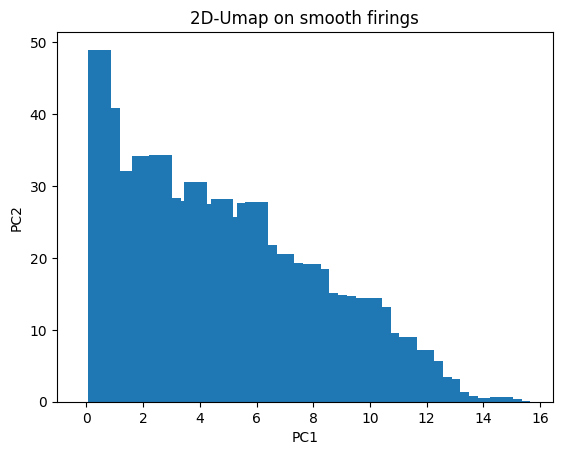

In [37]:
bins, rad_density = calculate_radial_density(umap_smooth_3d)

plt.figure()
plt.title('2D-Umap on smooth firings')
plt.bar(bins, rad_density)
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.xlim(-.01, .2)
#plt.ylim(-0.01, .4)
plt.show()

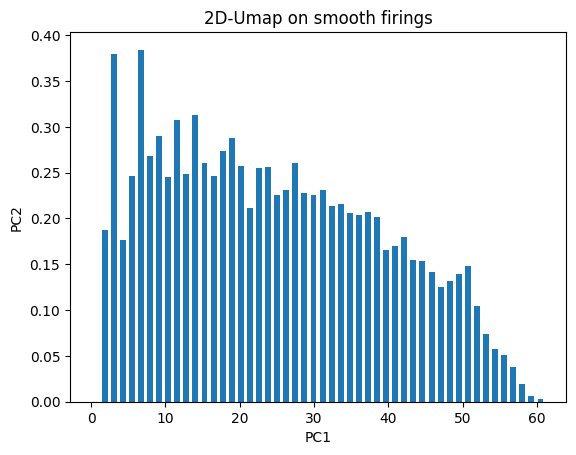

In [41]:
bins, rad_density = calculate_radial_density(tsne_smooth_3d)

plt.figure()
plt.title('2D-Umap on smooth firings')
plt.bar(bins, rad_density)
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.xlim(-.01, .2)
#plt.ylim(-0.01, .4)
plt.show()

# TRY VARIOUS CORRELATION METRICS

In [48]:
from matplotlib.colors import LogNorm
import quantities as pq

from elephant.conversion import BinnedSpikeTrain
from neo.core import SpikeTrain

from elephant.spike_train_correlation import covariance
from elephant.spike_train_correlation import correlation_coefficient as correlation
from elephant.spike_train_correlation import spike_time_tiling_coefficient as sttc
from elephant.spike_train_correlation import spike_time_tiling_coefficient as sttc
from elephant.spike_train_dissimilarity import victor_purpura_distance as vpd
from elephant.spike_train_dissimilarity import van_rossum_distance as vrd
from elephant.spike_train_synchrony import spike_contrast

In [49]:
def convolve_firings(binary_firings,
                     dt = 50,
                     sample_rate = 20000):
    firings_conv = np.zeros_like(binary_firings)
    window = np.ones(int(2*dt*sample_rate/1e3))
    for i, train in tqdm(enumerate(binary_firings)):
        firings_conv[i] = np.clip(np.convolve(train, window, mode='same'), 0, 1)
    return firings_conv


def STTC(binary_firings : np.array,
         dt : float = 50,
         sample_rate : int = 20000,
         firings_conv = None):
    size = np.shape(binary_firings)[0]
    sttc = np.ones((size, size))

    if firings_conv == None:
        firings_conv = convolve_firings(binary_firings, dt, sample_rate)

    T = np.sum(firings_conv, axis=0)/size

    for i in tqdm(range(size)):
        for j in range(i+1, size):
            P_i = np.sum(binary_firings[i] * firings_conv[j])/np.sum(binary_firings[i])
            P_j = np.sum(binary_firings[j] * firings_conv[i])/np.sum(binary_firings[j])

            sttc[i, j] = 1/2 * ( (P_i - T[j]) / (1 - P_i*T[j]) + (P_j - T[i]) / (1 - P_j*T[i]) )
            sttc[j, i] = sttc[i, j]

    return sttc

In [50]:
sttc_result = STTC(binary_firings)

136it [01:57,  1.16it/s]
100%|██████████| 136/136 [01:41<00:00,  1.35it/s]


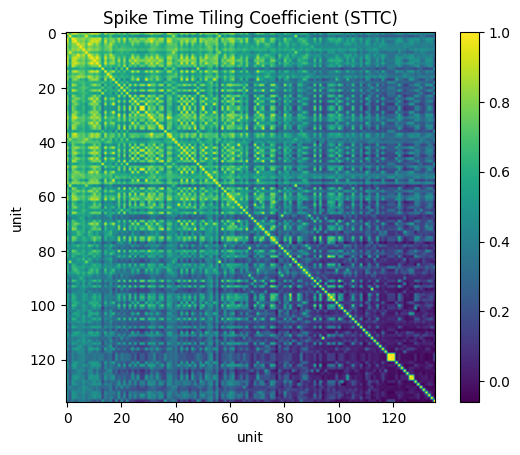

In [52]:
plt.imshow(sttc_result)
plt.title('Spike Time Tiling Coefficient (STTC)')
plt.colorbar()
plt.xlabel('unit')
plt.ylabel('unit')
plt.show()

100%|██████████| 136/136 [00:00<00:00, 147.32it/s]


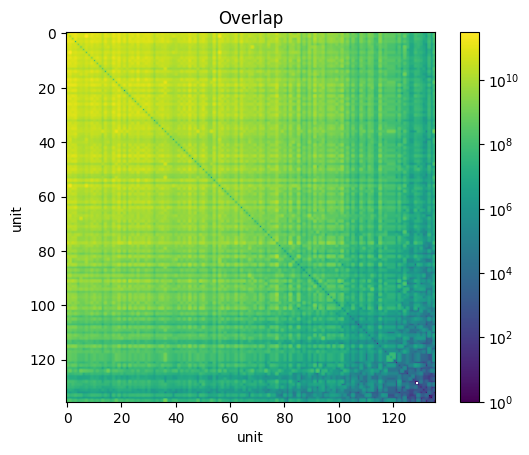

In [55]:
def pairwise_corr(firing_rates):
    size = np.shape(firing_rates)[0]
    correlations = np.zeros((size, size))
    for i in tqdm(range(size)):
        for j in range(i+1, size):
            cross_corr = np.sum(firing_rates[i]*firing_rates[j])
            correlations[i, j] = cross_corr
            correlations[j, i] = cross_corr

    return correlations

corr = pairwise_corr(firing_rates)

plt.imshow(corr, norm=LogNorm(vmin=1, vmax=np.max(corr)), cmap='viridis')
plt.title('Overlap')
plt.colorbar()
plt.xlabel('unit')
plt.ylabel('unit')
plt.show()

In [56]:
sample_rate = 20000
t_stop = total_size / sample_rate
spike_trains = []

for unit in units:
    spike_trains.append(SpikeTrain(units[0]['spike_train']/sample_rate, t_stop=t_stop, units=pq.s))

binned_spike_trains = BinnedSpikeTrain(binary_firings, bin_size=1/sample_rate*pq.s, t_stop=t_stop*pq.s)

[2024-11-04 17:39:40,478] utils - WARNING: Correcting a rounding error in the calculation of the number of bins by incrementing the value by 1. You can set tolerance=None to disable this behaviour.


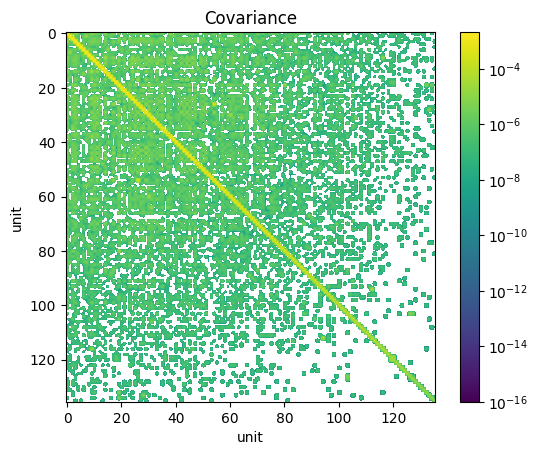

In [57]:
cov = covariance(binned_spike_trains, fast=False)

plt.imshow(cov, norm=LogNorm(vmin=1e-16, vmax=np.max(cov)), cmap='viridis')
plt.title('Covariance')
plt.colorbar()
plt.xlabel('unit')
plt.ylabel('unit')
plt.show()

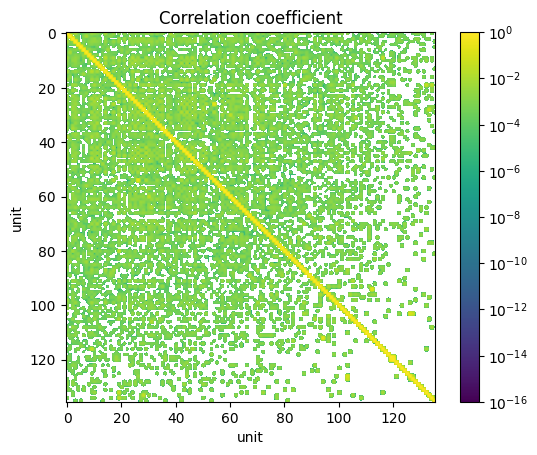

In [58]:
corr = correlation(binned_spike_trains, fast=False)

plt.imshow(corr, norm=LogNorm(vmin=1e-16, vmax=np.max(corr)), cmap='viridis')
plt.title('Correlation coefficient')
plt.colorbar()
plt.xlabel('unit')
plt.ylabel('unit')
plt.show()

In [95]:
def STTC_elephant(spike_trains, sample_rate : int = 20000):
    size = len(spike_trains)
    correlations = np.zeros((size, size))

    for i in tqdm(range(size)):
        st1 = spike_trains[i]
        for j in range(i+1, size):
            st2 = spike_trains[2]
            result = sttc(st1, st2)
            correlations[i, j] = result
            correlations[j, i] = result

    return correlations

sttc_result = STTC_elephant(spike_trains)

100%|██████████| 136/136 [4:48:26<00:00, 127.25s/it] 


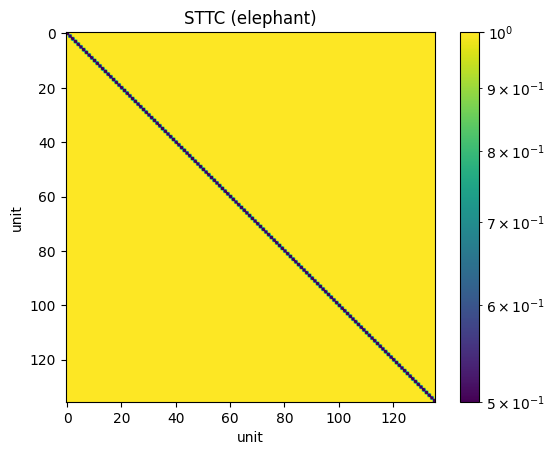

In [99]:
plt.imshow(sttc_result, norm=LogNorm(vmin=.5, vmax=np.max(sttc_result)), cmap='viridis')
plt.title('STTC (elephant)')
plt.colorbar()
plt.xlabel('unit')
plt.ylabel('unit')
plt.show()

In [100]:
sttc_result

array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.]])

In [ ]:
vpd_result = vpd(spike_trains)

In [72]:
vpd_result

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.

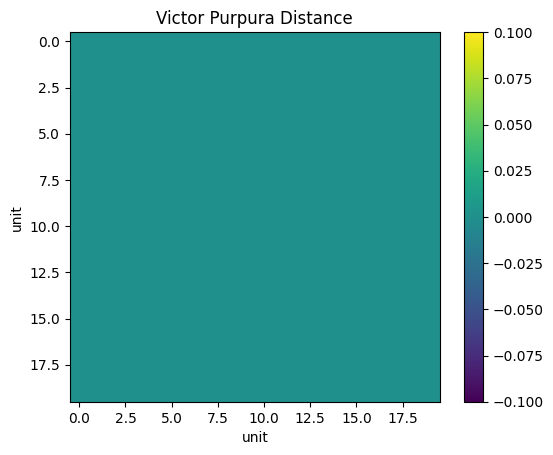

In [73]:
plt.imshow(vpd_result, cmap='viridis')
plt.title('Victor Purpura Distance')
plt.colorbar()
plt.xlabel('unit')
plt.ylabel('unit')
plt.show()

In [91]:
vrd_result = vrd(spike_trains, sort=False)

In [92]:
np.shape(vrd_result)

(136, 136)

In [93]:
np.min(vrd_result), np.max(vrd_result)

(0.0, 0.0)

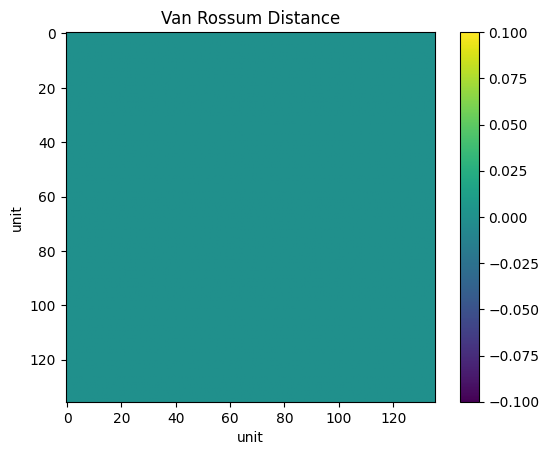

In [94]:
plt.imshow(vrd_result, cmap='viridis')
plt.title('Van Rossum Distance')
plt.colorbar()
plt.xlabel('unit')
plt.ylabel('unit')
plt.show()